In [1]:
import os
import sys
from dotenv import load_dotenv
import numpy as np

load_dotenv()

BASE_PATH = os.getenv('ROOT_PATH')
os.chdir(BASE_PATH)
if BASE_PATH not in sys.path:
    sys.path.insert(0, BASE_PATH)

print("Base path set to:", BASE_PATH)

Base path set to: /Users/thomasstycke/Desktop/DTU/Computational Tools for Data Science/CompToolsGrp70


In [2]:
from src.models.recommend import recommend_for_new_user, recommend_for_existing_user, evaluate_leave_one_out


In [3]:
recs = recommend_for_new_user([(1, 2.0), (2, 1.5), (6, 1.0)], top_n=2)
print(recs)


[{'movieId': 101425, 'title': 'Company (2011)', 'score': 5.973740577697754}, {'movieId': 57038, 'title': 'To the Left of the Father (Lavoura Arcaica) (2001)', 'score': 5.962336540222168}]


Predicting: 100%|██████████| 305/305 [00:26<00:00, 11.32it/s]


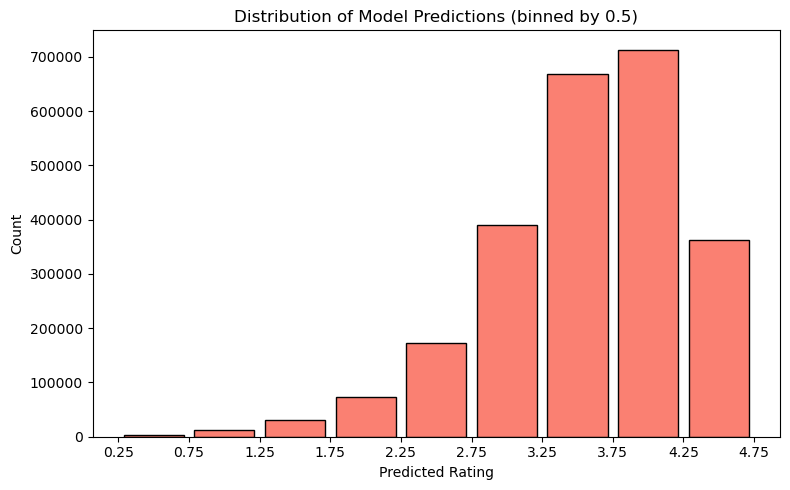

0.2-0.8: 3,438
0.8-1.2: 12,815
1.2-1.8: 31,251
1.8-2.2: 72,744
2.2-2.8: 173,528
2.8-3.2: 389,654
3.2-3.8: 668,380
3.8-4.2: 713,212
4.2-4.8: 362,827


In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.models.ncf_model import NeuralCF
from src.models.ncf_dataset import RatingsDataset

# --- paths ---
TEST_PATH = "data/gold/test.parquet"
CKPT_PATH = "models/ncf.pt"

# --- load test dataset ---
test_ds = RatingsDataset(TEST_PATH)
test_loader = DataLoader(test_ds, batch_size=8192, shuffle=False, num_workers=2)

# --- load model checkpoint ---
ckpt = torch.load(CKPT_PATH, map_location="cpu")
model = NeuralCF(
    n_users=ckpt["n_users"],
    n_items=ckpt["n_items"],
    emb_dim=ckpt["emb_dim"],
    hidden=ckpt["hidden"],
    dropout=ckpt["dropout"],
)
model.load_state_dict(ckpt["model_state"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- collect predictions ---
preds = []
with torch.no_grad():
    for users, items, ratings in tqdm(test_loader, desc="Predicting"):
        users, items = users.to(device), items.to(device)
        batch_preds = model(users, items).cpu().numpy()
        preds.extend(batch_preds)

preds = np.array(preds)

# --- bin predictions into 0.5 increments ---
bins = np.arange(0.25, 5.25, 0.5)
plt.figure(figsize=(8,5))
plt.hist(preds, bins=bins, color="salmon", edgecolor="black", rwidth=0.85)
plt.xticks(bins)
plt.xlabel("Predicted Rating")
plt.ylabel("Count")
plt.title("Distribution of Model Predictions (binned by 0.5)")
plt.tight_layout()
plt.show()

# (optional) print summary
hist, bin_edges = np.histogram(preds, bins=bins)
for i in range(len(hist)):
    print(f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}: {hist[i]:,}")


In [5]:
import pandas as pd, numpy as np, math

test = pd.read_parquet("data/gold/test.parquet")
gmean = test["rating"].mean()
loss_global = math.sqrt(((test["rating"] - gmean)**2).mean())
print("Global-mean loss:", loss_global)

# item-mean baseline
item_mean = test.groupby("movie_idx")["rating"].mean()
loss_item = math.sqrt(((test["rating"] - test["movie_idx"].map(item_mean))**2).mean())
print("Item-mean loss:", loss_item)

# user-mean baseline
user_mean = test.groupby("user_idx")["rating"].mean()
loss_user = math.sqrt(((test["rating"] - test["user_idx"].map(user_mean))**2).mean())
print("User-mean loss:", loss_user)


Global-mean loss: 1.0613194102208974
Item-mean loss: 0.9526049023530322
User-mean loss: 0.9183295656831951


In [6]:
import torch, numpy as np
from torch.utils.data import DataLoader
from src.models.ncf_dataset import RatingsDataset
from src.models.ncf_model import NeuralCF

# collect preds on test
ds = RatingsDataset("data/gold/test.parquet")
loader = DataLoader(ds, batch_size=8192, shuffle=False)
ckpt = torch.load("models/ncf.pt", map_location="cpu")
m = NeuralCF(ckpt["n_users"], ckpt["n_items"], ckpt["emb_dim"], ckpt["hidden"], ckpt["dropout"])
m.load_state_dict(ckpt["model_state"]); m.eval()

preds = []
with torch.no_grad():
    for u,i,r in loader:
        preds.append(m(u, i).numpy())
preds = np.concatenate(preds)

print("Pred range:", preds.min(), preds.max())
print("Pred percentiles:", np.percentile(preds,[1,5,25,50,75,95,99]))


Pred range: -1.4998817 6.28273
Pred percentiles: [1.42603267 2.26802444 3.1919204  3.68091965 4.09595871 4.61244383
 4.92383589]


In [7]:
ids = np.random.randint(0, 30000, size=1000)
results = evaluate_leave_one_out(ids, n_samples_per_user=5)


⚠️  Skipping user 15183 (not enough ratings)
⚠️  Skipping user 5053 (not enough ratings)
⚠️  Skipping user 17866 (not enough ratings)
⚠️  Skipping user 24728 (not enough ratings)
⚠️  Skipping user 12481 (not enough ratings)
⚠️  Skipping user 5536 (not enough ratings)
⚠️  Skipping user 10216 (not enough ratings)
⚠️  Skipping user 29745 (not enough ratings)
⚠️  Skipping user 5415 (not enough ratings)
⚠️  Skipping user 9034 (not enough ratings)
⚠️  Skipping user 20809 (not enough ratings)
⚠️  Skipping user 7987 (not enough ratings)
⚠️  Skipping user 13001 (not enough ratings)
⚠️  Skipping user 20803 (not enough ratings)
⚠️  Skipping user 4270 (not enough ratings)
⚠️  Skipping user 8411 (not enough ratings)
⚠️  Skipping user 3158 (not enough ratings)
⚠️  Skipping user 16786 (not enough ratings)
⚠️  Skipping user 25925 (not enough ratings)
⚠️  Skipping user 12419 (not enough ratings)
⚠️  Skipping user 21859 (not enough ratings)
⚠️  Skipping user 27201 (not enough ratings)
⚠️  Skipping user 

/var/folders/m4/lvsr74wx0q925cvzc6z0g13r0000gn/T/ipykernel_9505/1214927594.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias = df.groupby("true_bin")["pred_rating"].mean()


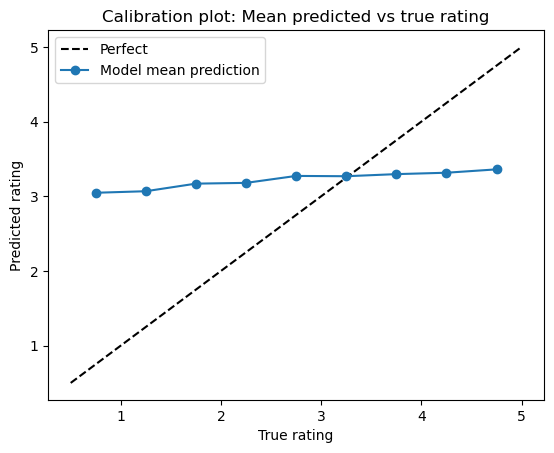

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bins = np.arange(0.5, 5.5, 0.5)
df = results.copy()
df["true_bin"] = pd.cut(df["true_rating"], bins=bins, right=False)

# Compute mean prediction per true-rating bin
bias = df.groupby("true_bin")["pred_rating"].mean()

# Get midpoints of bins
midpoints = [interval.mid for interval in bias.index.categories]

plt.plot([0.5,5.0], [0.5,5.0], 'k--', label="Perfect")
plt.plot(midpoints, bias.values, 'o-', label="Model mean prediction")

plt.xlabel("True rating")
plt.ylabel("Predicted rating")
plt.title("Calibration plot: Mean predicted vs true rating")
plt.legend()
plt.show()
